# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 05

**Author 1 (sciper):** Lavinia Schlyter (284566)
**Author 2 (sciper):** Simon Gilgien (253797)  


**Release date:** 07.04.2022
**Due date:** 29.04.2022


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
# Extra imports
import itertools
import math
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np


---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [3]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### Data visalisation
Since each data point is 2-dimensional, an easy way to visalize it is to print a scatter plot of each data point with a different color for each class.

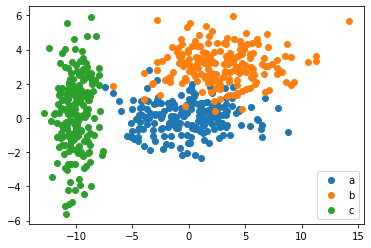

In [4]:
plt.scatter(a[:, 0], a[:, 1], label="a")
plt.scatter(b[:, 0], b[:, 1], label="b")
plt.scatter(c[:, 0], c[:, 1], label="c")
_ = plt.legend()

### 1.1 Bayes method (5 pts)
Using the Bayes method, give the expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data. Note that you do not need to solve the analytical expression. You can simply evaluate the function for each point on the plane to end up with a segmentation map.
For simplicity reasons, round the estimated parameters to the closest integer value.

Each data class is regrouped in one point cloud, with the density of points decreasing with the distance to the center of the cloud. Therefore it is reasonnable to approximate the distribution of each class by a 2D Gaussian distribution.

In [5]:
# Add your implementation and discussion
def estimate_gaussian(training_data):
    """"Given a training dataset of size (N, 2), estimate the parameters of a Gaussian distribution.
    Returns a tuple containing the mean value vector and the covariance matrix"""
    
    mean = training_data.mean(axis=0)
    
    residuals = training_data - mean
    
    variations = residuals[:, :, None] @ residuals[:, None, :]
    
    # Compute the unbiased estimator of the covariance
    covariance = variations.sum(axis=0) / (variations.shape[0] - 1)
    
    return mean, covariance

gaussians = [estimate_gaussian(data) for data in (a, b, c)]

def gaussian_probability(gaussian, sample):
    """Given the parameter of a gaussian and a sample, compute the probabilty P(sample | gaussian)"""
    mean, covariance = gaussian
    
    residual = sample - mean
    return np.exp(-0.5 * np.transpose(residual) @ np.linalg.inv(covariance) @ residual) / (2*math.pi * np.sqrt(np.linalg.det(covariance)))

Since the prior probability is the same for all 3 classes, the probabilty of a given sample $x$ being in a class $w_i$ is proportional to the probability density of the distribution for the class $w_i$ at $x$: $P(w_i | x) \propto P(x | w_i)$.

We sample a region of the plane and compute the most probable class for each sample point.

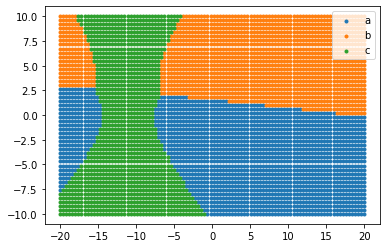

In [6]:
samples_by_category = [[], [], []]
segmentation_map = {}

for x, y in itertools.product(np.linspace(-20, 20, 100), np.linspace(-10, 10, 50)):
    sample = np.array([x, y])
    probs = [gaussian_probability(gaussian, sample) for gaussian in gaussians]
    
    category = np.argmax(probs)
    samples_by_category[category].append([x, y])
    segmentation_map[x, y] = category

labels = ["a", "b", "c"]

for i in range(3):
    # convert to numpy array to have easier indexing
    samples_by_category[i] = np.array(samples_by_category[i])
    plt.scatter(samples_by_category[i][:, 0], samples_by_category[i][:, 1], marker=".", label=labels[i])
    
_ = plt.legend()

The separation curves between the regions are the points where the probability for two classes are equal: $P(w_i | x) = P(w_j | x)$, or equivalently $P(x | w_i) = P(x | w_j)$. Note that we are only interested in the portions of those curves where the probability for the third class is smaller than the two equal probabilities.

Due to the fact that we use a Gaussian distribution, the separation curves are quadratic. Deriving the analytic formula is not easy, but we can approximate the curves by looking at points on the segmentation map where the predicted category changes.

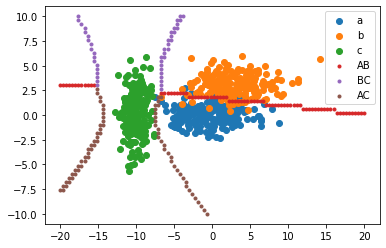

In [7]:
curve_ab = []
curve_bc = []
curve_ac = []

prev_x = None

for x in np.linspace(-20, 20, 100):
    
    prev_y = None
    
    for y in np.linspace(-10, 10, 50):
        category = segmentation_map[x, y]
        categories = None
        if segmentation_map.get((prev_x, y), category) != category:
            categories = {category, segmentation_map[prev_x, y]}
        if segmentation_map.get((x, prev_y), category) != category:
            categories = {category, segmentation_map[x, prev_y]}

        if categories == {0, 1}:
            curve_ab.append([x, y])
        elif categories == {1, 2}:
            curve_bc.append([x, y])
        elif categories == {0, 2}:
            curve_ac.append([x, y])
            
        prev_y = y
        
    prev_x = x
    
    
plt.scatter(a[:, 0], a[:, 1], label="a")
plt.scatter(b[:, 0], b[:, 1], label="b")
plt.scatter(c[:, 0], c[:, 1], label="c")
        
for curve, label in zip([curve_ab, curve_bc, curve_ac], ["AB", "BC", "AC"]):
    curve = np.array(curve)
    plt.scatter(curve[:, 0], curve[:, 1], marker=".", label=label)

_ = plt.legend()

As we can see on the plot, the curves we find give a reasonable segmentation of the plane, and each curve is part of a quadratic curve.

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

In [8]:
# Add your implementation and discussion

def mahalanobis_distance(gaussian, sample):
    mean, covariance = gaussian

    residual = sample - mean
    return np.sqrt(np.transpose(residual) @ np.linalg.inv(covariance) @ residual)


Given a Gaussian probability density function of mean $\mu$ and covariance $\Sigma$, the Mahalanobis distance of a sample $x$ to the Gaussian approximation is given by $$d = \sqrt{(x - \mu) \Sigma^{-1} (x - \mu)}$$

If we expand and simplify this formula in the 2D case, we get, with $x = (x, y)$, $\mu = (\mu_1, \mu_2)$ and
$$\Sigma^{-1} = \begin{pmatrix}\sigma_{00} & \sigma_{01}\\ \sigma_{01} & \sigma_{11}\end{pmatrix}$$

$$d = \sqrt{x^2 \sigma_{00} + x (-2\mu_0 \sigma_{00} - 2\mu_1\sigma_{01}) + x y (2\sigma_{01}) + y (-2\mu_0 \sigma_{01} -2 \mu_1 \sigma_{11}) + y^2 \sigma_{11} + (\mu_0^2 \sigma_{00} + 2 \mu_0 \mu_1 \sigma_{01} + \mu_1^2 \sigma_{11})} = \sqrt{x^2 a + x b + x y c + y d + y^2 e + f}$$

We can compute the coefficients $a$, $b$, $c$, $d$, $e$ and $f$ for the different gaussian functions:

In [9]:
def mahalanobis_coeffs(gaussian):
    mean, covariance = gaussian
    
    sigma = np.linalg.inv(covariance)
    
    a = sigma[0, 0]
    b = -2 * (mean[0]*sigma[0, 0] + mean[1]*sigma[0, 1])
    c = 2*sigma[0, 1]
    d = -2 * (mean[0]*sigma[0, 1] + mean[1]*sigma[1, 1])
    e = sigma[1, 1]
    f = np.transpose(mean) @ np.linalg.inv(covariance) @ mean
    
    return a, b, c, d, e, f

print(mahalanobis_coeffs(gaussians[0]))
print(mahalanobis_coeffs(gaussians[1]))

(0.099929488488715, 0.04292591903508372, -0.03134191940245821, -0.0793615139922488, 1.1938886627649368, 0.00571671928200892)
(0.09861563439173776, -0.45248439715418187, -0.03279371509965637, -5.558627959158717, 0.9252323003578354, 9.120721754750155)


We can compare segmentation maps obtained using the full Bayes classification and the Mahalanobis distance:

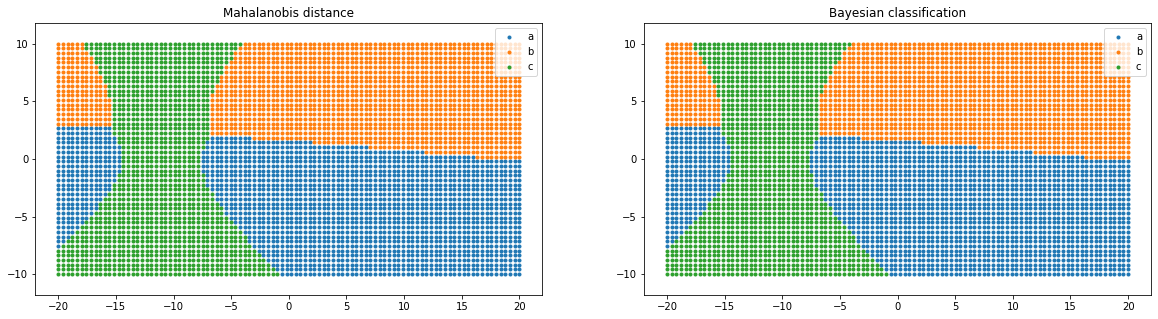

In [10]:
samples_by_category_mahalanobis = [[], [], []]

for x, y in itertools.product(np.linspace(-20, 20, 100), np.linspace(-10, 10, 50)):
    sample = np.array([x, y])
    distances = [mahalanobis_distance(gaussian, sample) for gaussian in gaussians]
    
    category = np.argmin(distances)
    samples_by_category_mahalanobis[category].append([x, y])

labels = ["a", "b", "c"]


plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)

for i in range(3):
    # convert to numpy array to have easier indexing
    samples_by_category_mahalanobis[i] = np.array(samples_by_category[i])
    plt.scatter(samples_by_category[i][:, 0], samples_by_category[i][:, 1], marker=".", label=labels[i])
    
plt.legend()
plt.title("Mahalanobis distance")
plt.axis("equal")

plt.subplot(1, 2, 2)

for i in range(3):
    plt.scatter(samples_by_category[i][:, 0], samples_by_category[i][:, 1], marker=".", label=labels[i])
    
plt.legend()
plt.title("Bayesian classification")
_ = plt.axis("equal")

We can also compare the figures for a few random points:

In [11]:
import random

random.seed(0)

for i in range(10):
    x = random.uniform(-20, 20)
    y = random.uniform(-10, 10)
    
    sample = np.array([x, y])
    
    prob_a = gaussian_probability(gaussians[0], sample)
    prob_b = gaussian_probability(gaussians[1], sample)
    
    dist_a = mahalanobis_distance(gaussians[0], sample)
    dist_b = mahalanobis_distance(gaussians[1], sample)
    
    print(f"Point ({x: =7.3f}, {y: =6.3f}): Probability a: {prob_a:.3e} {'>' if prob_a > prob_b else '<'} b: {prob_b:.3e} Distance a: {dist_a: >6.3f} {'>' if dist_a > dist_b else '<'} b: {dist_b: >6.3f}")

Point ( 13.777,  5.159): Probability a: 1.458e-12 < b: 2.376e-05 Distance a:  6.979 > b:  3.902
Point (- 3.177, -4.822): Probability a: 3.492e-08 > b: 6.175e-15 Distance a:  5.342 < b:  7.705
Point (  0.451, -1.901): Probability a: 5.676e-03 > b: 5.168e-07 Distance a:  2.131 < b:  4.783
Point ( 11.352, -3.934): Probability a: 2.837e-09 > b: 7.610e-14 Distance a:  5.793 < b:  7.372
Point (- 0.936,  1.668): Probability a: 1.060e-02 < b: 1.079e-02 Distance a:  1.814 > b:  1.728
Point ( 16.325,  0.094): Probability a: 6.507e-08 > b: 5.252e-08 Distance a:  5.224 < b:  5.239
Point (- 8.726,  5.116): Probability a: 1.466e-10 < b: 6.475e-06 Distance a:  6.284 > b:  4.222
Point (  4.735, -4.990): Probability a: 3.207e-09 > b: 3.106e-15 Distance a:  5.772 < b:  7.793
Point ( 16.390,  9.656): Probability a: 6.754e-31 < b: 4.064e-14 Distance a: 11.538 > b:  7.456
Point ( 12.409,  8.043): Probability a: 2.125e-21 < b: 1.107e-08 Distance a:  9.455 > b:  5.529


We can see that the Mahalanobis distance is always smaller for the class with the highest probability. In addition, the numbers involved cover a smaller range and are therefore less prone to floating-point inaccuracies. The Mahalanobis distance is also faster to compute than the full probability, so in practice it is easier to use it.

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [12]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [13]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

FileNotFoundError: [Errno 2] No such file or directory: '../data/lab-03-data/part2/train-images-idx3-ubyte.gz'

In [ ]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [ ]:
X_train = train_images.copy()
X_test = test_images.copy()

X_train = X_train.reshape(np.shape(X_train)[0], -1)
X_test = X_test.reshape(np.shape(X_test)[0],-1)
y_train = train_labels.copy()
y_test = test_labels.copy()

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
# Careful ! Use train fit scalar on test
X_test = sc.transform (X_test)

Please note that due to time/computational constraints, hyper-parameters were not tuned.

Several solvers were tested, including:
- **adam**: Gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments
- **lbfgs**: limited memory quasi-Newton optimization 
- **sgd**: Stochastic gradient descent

In [ ]:
# Solver = Adam 
mlp_adam = MLPClassifier(hidden_layer_sizes=(100,), alpha=0.0001, solver= 'adam', random_state=999)
mlp_adam.fit(X_train, y_train)

In [ ]:

print(f"ADAM: Training accuracy score: {accuracy_score(mlp_adam.predict(X_train), y_train)}")
print(f"ADAM: Test accuracy score: {accuracy_score(mlp_adam.predict(X_test), y_test)}")


In [ ]:
# Solver = lbfgs
mlp_lbfgs = MLPClassifier(hidden_layer_sizes=(100,), alpha=0.0001, solver= 'lbfgs', random_state=999)
mlp_lbfgs.fit(X_train, y_train)

In [ ]:

print(f"LBFGS: Training accuracy score: {accuracy_score(mlp_lbfgs.predict(X_train), y_train)}")
print(f"LBFGS: Test accuracy score: {accuracy_score(mlp_lbfgs.predict(X_test), y_test)}")


In [ ]:
# Solver = sgd
mlp_sgd = MLPClassifier(hidden_layer_sizes=(100,), alpha=0.0001, solver= 'sgd', random_state=999)
mlp_sgd.fit(X_train, y_train)

In [ ]:

print(f"SGD: Training accuracy score: {accuracy_score(mlp_sgd.predict(X_train), y_train)}")
print(f"SGD: Test accuracy score: {accuracy_score(mlp_sgd.predict(X_test), y_test)}")


All three solvers perform with an accuracy around 97% on the test set. The training scores above as it is the dataset on which the network is trained. Note that we have signs of overfitting with accuarcy that reach 100% for the LBFGS solver. 


### Where does the network innacurately perform 

Using the optimizer which performed best on the test set (in this instance), we take a deeper look into which digits were missclassified


In [ ]:
# Wrongly classified images
import random

random.seed(999)
# Wrongly classified test set indexes
missclass_image_id = np.where(mlp_sgd.predict(X_test)!= y_test)[0]
# Pick 10 random images id of the wrongly classified ones
random_10_wrong = random.choices(missclass_image_id, k = 10)

In [ ]:
# Compute the probabilities of the wrongly classified images 
random_10_proba = mlp_sgd.predict_proba(X_test)[random_10_wrong]

In [ ]:
fig, axs = plt.subplots(2, 10, figsize=(32,6))
ax = axs.ravel()


for ind, image_id in enumerate(random_10_wrong):
    ax[2*ind].imshow(test_images[image_id].reshape(28,28), cmap='gray') # Print initial image
    ax[2*ind].axis('off')
    ax[2*ind].set_title(f"True: {y_test[image_id]}, Pred: {mlp_sgd.predict(X_test)[image_id]}")
    
    width = 0.5
    x_digits = np.arange(len(random_10_proba[0]))
    ax[2*ind+1].barh(x_digits,random_10_proba[ind], width)
    ax[2*ind+1].set_yticks(x_digits)
    ax[2*ind+1].set_yticklabels(x_digits)
    ax[2*ind+1].set_xlim(0,1)

plt.show()
    

In the figure above, we look at the test digits in its initial state as well as the prediction probability vector. In the title we have the true label as well as the predicted one through the network.

We note that some digits that to the eye seem obvious such as the top left-most zero is not a seven nor is it a three.
Others such as the bottom right-most corner is predicted as seven with the highest probability with a human eye probability estiamted the same result. 

The network is not perfect but on top of its 97% accuarcy on the test set remains rather impressive. In order to increase this accuracy one should tune the hyper-parameters, proceed with some additional feature engineering as well as increase the network size. 


#### Extra 
If more time could be used to run the notebook, one could use GridSearchCV in order to tune the hyperparameters for a possibly better result 



In [ ]:
RUN_extra = False

if RUN_extra:

    mlp = MLPClassifier(hidden_layer_sizes = (100,))
    parameter_mlp = {
        "mlp__activation": ["logistic","tanh", "relu"],
        "mlp__solver": ["sgd", "adam", "lbfgs"],
        "mlp__alpha": 10.0**(-np.arange(1, 7))
    }

    # Define a Standard Scaler to normalize inputs
    scaler = StandardScaler()
    pipe = Pipeline(steps=[("scaler", scaler), ("mlp", mlp)])
    clf = RandomizedSearchCV(pipe, parameter_mlp, n_jobs=1, cv=2, verbose = 1)
    clf.fit(X_train, y_train)



    print('Best parameters found:\n', clf.best_params_)
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    y_test_pred = clf.predict_proba(y_test)   
    print(classification_report(y_test, y_test_pred))